In [1]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
import jax.random as random
from functools import partial
from typing import Callable, Union
from collections import namedtuple
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

from kernel import imq_kernel, rbf_kernel
from model import model
from methods import VGD
from experiment import experiment, diagnostic_experiment
from calculate_mmd import calculate_mmd_squared
from plot_functions import plot_predictives, plot_main_figure


def quadratic_reg(theta, x):
    return theta * x**2

quad_model = model(0.5, quadratic_reg, theta_dim=1)

def my_sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def sigmoid_reg(theta, x):
    return 1 / (1 + jnp.exp(-theta * x))

sig_model = model(0.05, sigmoid_reg, theta_dim=1)

def linear_reg(theta, x):
    return theta[0] + theta[1] * x

linear_model = model(0.8, linear_reg, theta_dim=2)

d:\OneDrive - Newcastle University\Project_3_refactor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
data_quad_w = quad_model.generate_data(1000, 5, x_min=0.0, x_max=1.0, key=random.PRNGKey(12))
data_sig_w = sig_model.generate_data(1000, 5, x_min=-1.0, x_max=1.0, key=random.PRNGKey(34))

key = random.PRNGKey(12)
rng, key = random.split(key)
n_data = 1000
xs = random.uniform(rng, (n_data,))
true_theta = 5.
sigma = 0.5
phi = 3
rng, key = random.split(key)
ys = (true_theta + phi * random.normal(rng, xs.shape)) * jnp.square(xs)
rng, key = random.split(key)
ys += sigma * random.normal(rng, xs.shape)
data_quad_m = (xs, ys)

sigma = 0.05
def sigmoid(z):
  return 1 / (1 + jnp.exp(-z))
key = jax.random.PRNGKey(42) 
n_data = 1000
key, x_key = random.split(key)
x = random.uniform(x_key, (n_data,), minval=-1.0, maxval=1.0)
key, y_neg_key, y_pos_key = random.split(key, 3)
y_neg = random.uniform(y_neg_key, (n_data,), minval=0.0, maxval=0.5)
y_pos = random.uniform(y_pos_key, (n_data,), minval=0.5, maxval=1.0)
y_observed = jnp.where(x < 0, y_neg, y_pos)
data_sig_m = (x, y_observed)


true_theta = jnp.array([5.0, 3.0]) 
prior_mean = jnp.array([0.0, 0.0])
key = random.PRNGKey(12)
rng, key = random.split(key)
n_data = 1000
xs = random.uniform(rng, (n_data,), minval=-2.0, maxval=2.0)
sigma = 0.8
rng, key = random.split(key)
ys = true_theta[0] + true_theta[1] * xs
ys += sigma * random.normal(rng, xs.shape)
data_linear_w = (xs, ys)

true_theta = jnp.array([5.0, 3.0]) 
prior_mean = jnp.array([0.0, 0.0])
key = random.PRNGKey(12)
rng, key = random.split(key)
n_data = 1000
xs = random.uniform(rng, (n_data,), minval=-2.0, maxval=2.0) 
sigma = 0.8 
rng, key = random.split(key)
ys = true_theta[0] + true_theta[1] * xs + 2 * jnp.square(xs)
ys += sigma * random.normal(rng, xs.shape)
data_linear_m = (xs, ys)

## quad

In [28]:
experiment_quad_w = experiment(quad_model, data_quad_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_quad_w.run(n_steps=5000, step_size=0.001, lengthscale=0.1)

100%|██████████| 5000/5000 [00:06<00:00, 758.52it/s]


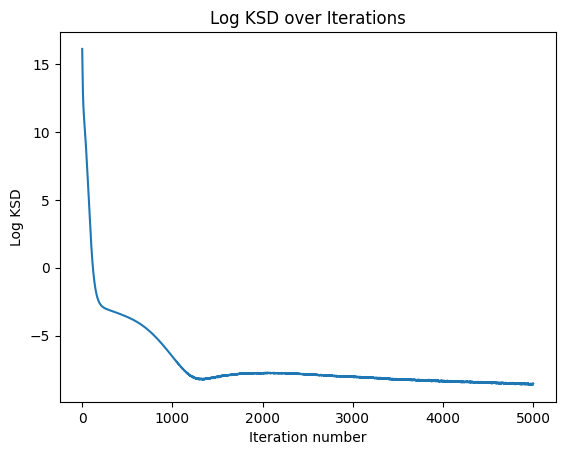

In [29]:
experiment_quad_w.plot_KSD()

100%|██████████| 5000/5000 [00:15<00:00, 322.38it/s]


MMD length scale: 1.4646633
Actual mmd 6.133032e-06


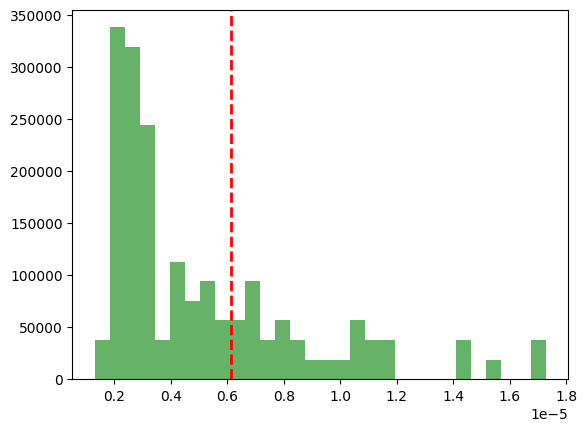

In [30]:
diagnostic_experiment_quad_w = diagnostic_experiment(experiment_quad_w)
all_mmd_values_quad_w, actual_mmd_quad_w = diagnostic_experiment_quad_w.plot_diagnostic()

In [31]:
experiment_quad_m = experiment(quad_model, data_quad_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_quad_m.run(n_steps=5000, step_size=0.0005, lengthscale=0.1)

100%|██████████| 5000/5000 [00:06<00:00, 784.87it/s]


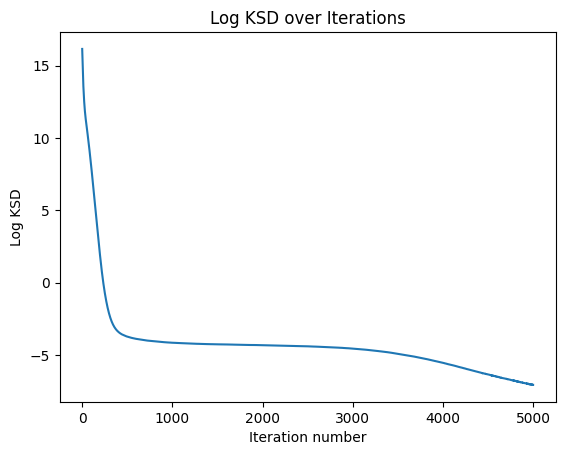

In [32]:
experiment_quad_m.plot_KSD()

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:14<00:00, 342.40it/s]


MMD length scale: 1.8091975
Actual mmd 0.00065050845


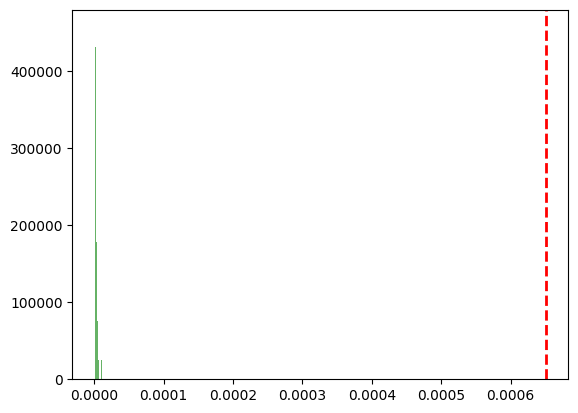

In [33]:
diagnostic_experiment_quad_m = diagnostic_experiment(experiment_quad_m)
all_mmd_values_quad_m, actual_mmd_quad_m = diagnostic_experiment_quad_m.plot_diagnostic()

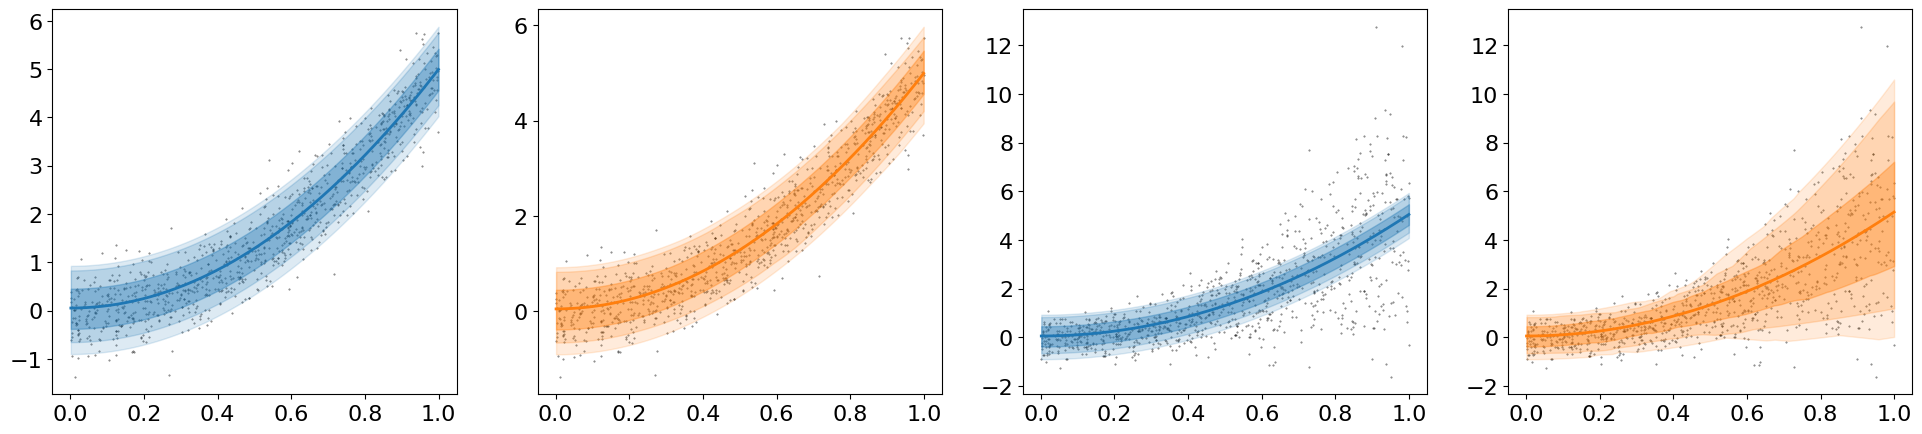

In [34]:
plot_predictives(experiment_quad_w, experiment_quad_m)

## sigmoid

In [61]:
experiment_sig_w = experiment(sig_model, data_sig_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_sig_w.run(n_steps=10000, step_size=0.001, lengthscale=0.1)

100%|██████████| 10000/10000 [00:12<00:00, 769.77it/s]


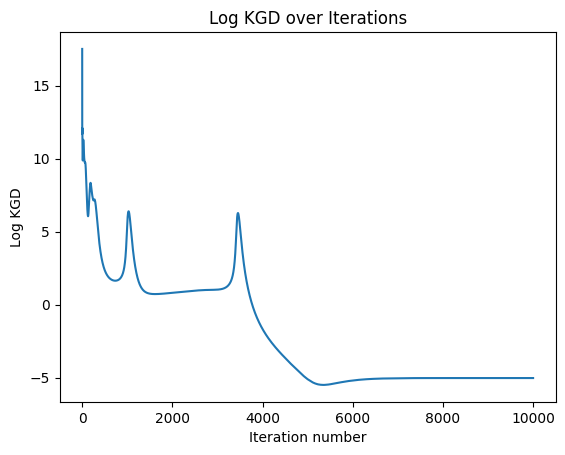

In [63]:
experiment_sig_w.plot_KGD()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:27<00:00, 368.79it/s]


MMD length scale: 0.39202666
Actual mmd 8.3939835e-07


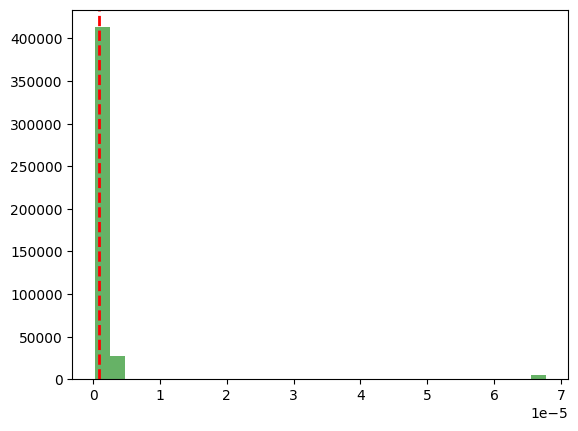

In [64]:
diagnostic_experiment_sig_w = diagnostic_experiment(experiment_sig_w)
all_mmd_values_sig_w, actual_mmd_sig_w = diagnostic_experiment_sig_w.plot_diagnostic()

In [24]:
experiment_sig_m = experiment(sig_model, data_sig_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_sig_m.run(n_steps=5000, step_size=0.0005, lengthscale=0.1)

100%|██████████| 5000/5000 [00:06<00:00, 734.71it/s]


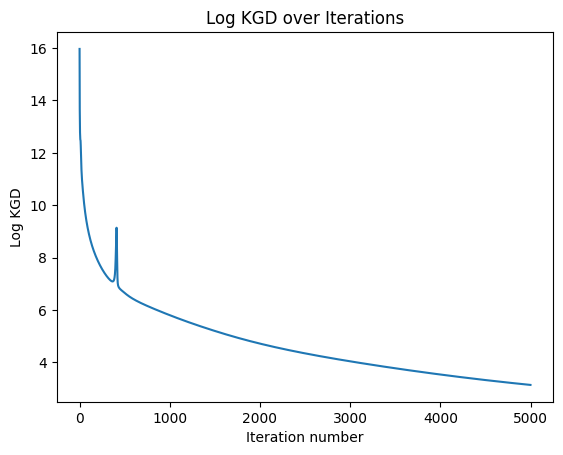

In [25]:
experiment_sig_m.plot_KGD()

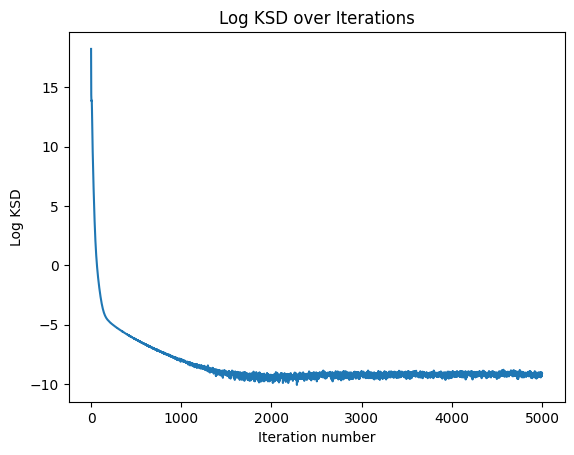

In [26]:
experiment_sig_m.plot_KSD()

100%|██████████| 5000/5000 [00:14<00:00, 339.49it/s]


MMD length scale: 0.2725378
Actual mmd 0.00072760845


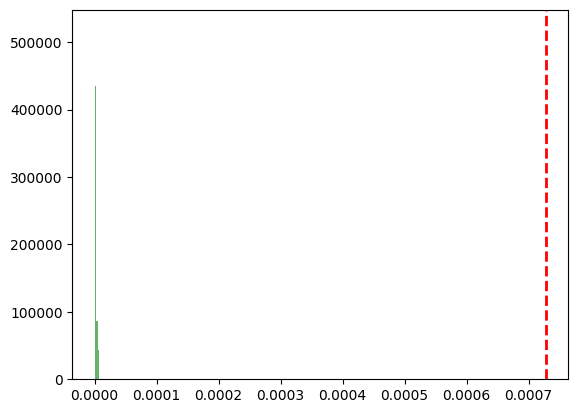

In [27]:
diagnostic_experiment_sig_m = diagnostic_experiment(experiment_sig_m)
all_mmd_values_sig_m, actual_mmd_sig_m = diagnostic_experiment_sig_m.plot_diagnostic()

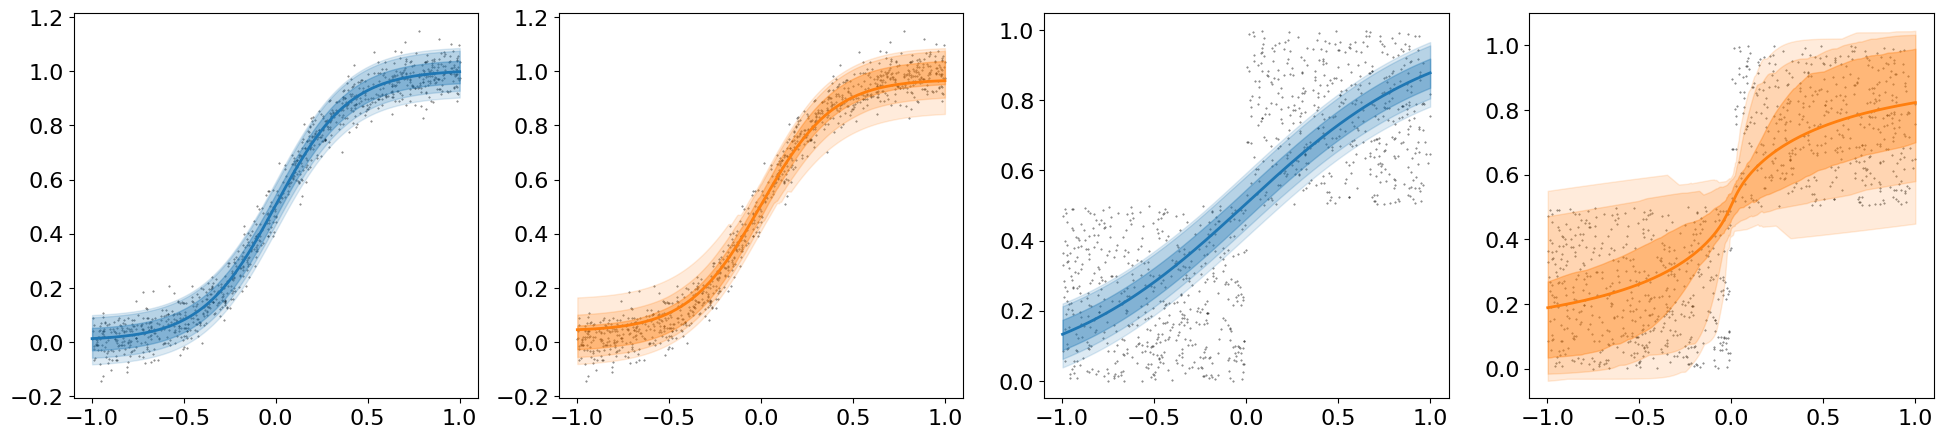

In [56]:
plot_predictives(experiment_sig_w, experiment_sig_m)

## linear and quadratic

In [16]:
experiment_landq_w = experiment(linear_model, data_linear_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_landq_w.run(n_steps=10000, step_size=0.0005, lengthscale=0.1)

100%|██████████| 10000/10000 [00:11<00:00, 833.74it/s]


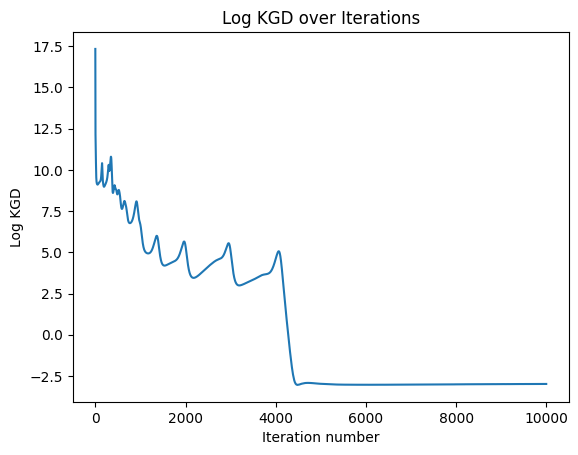

In [17]:
experiment_landq_w.plot_KGD()

100%|██████████| 10000/10000 [00:27<00:00, 362.17it/s]


MMD length scale: 3.4555707
Actual mmd 5.4387265e-06


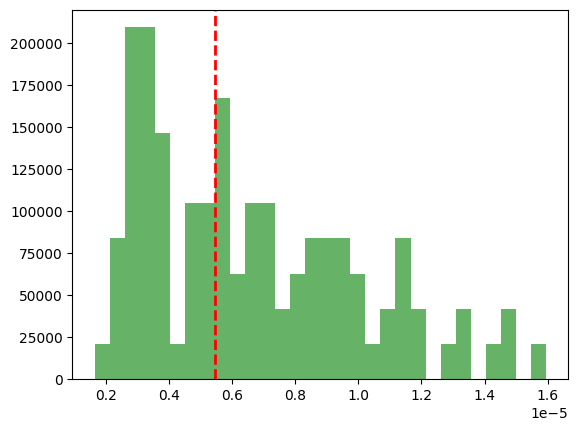

In [18]:
diagnostic_experiment_landq_w = diagnostic_experiment(experiment_landq_w)
all_mmd_values_landq_w, actual_mmd_landq_w = diagnostic_experiment_landq_w.plot_diagnostic()

In [19]:
experiment_landq_m = experiment(linear_model, data_linear_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_landq_m.run(n_steps=10000, step_size=0.0005, lengthscale=0.1)

100%|██████████| 10000/10000 [00:12<00:00, 826.80it/s]


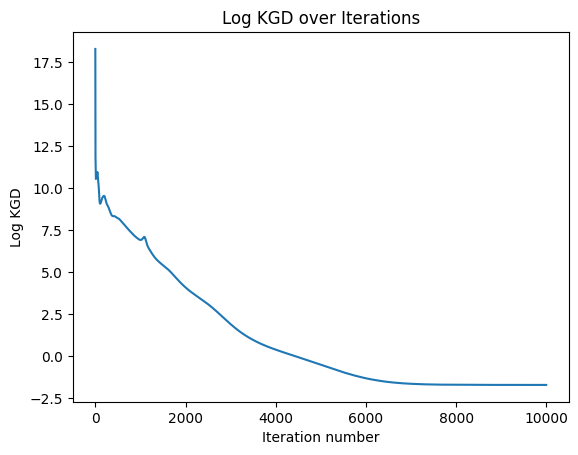

In [20]:
experiment_landq_m.plot_KGD()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:26<00:00, 376.17it/s]


MMD length scale: 4.9514174
Actual mmd 0.001738141


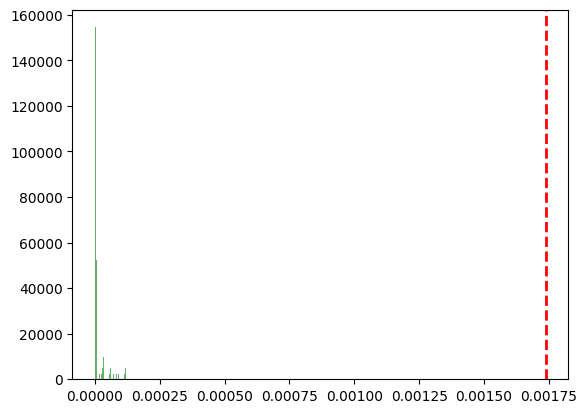

In [21]:
diagnostic_experiment_landq_m = diagnostic_experiment(experiment_landq_m)
all_mmd_values_landq_m, actual_mmd_landq_m = diagnostic_experiment_landq_m.plot_diagnostic()

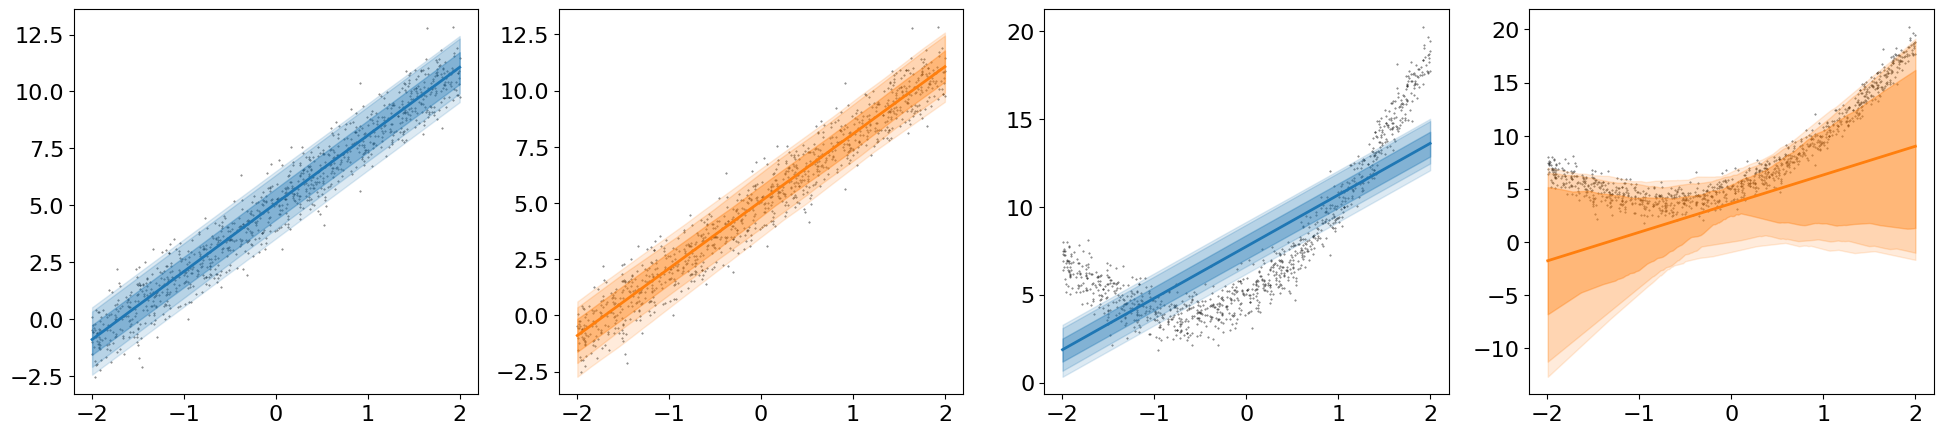

In [65]:
plot_predictives(experiment_landq_w, experiment_landq_m)

In [ ]:
data_to_save = {
    'experiment_quad_w': experiment_quad_w,
    'experiment_quad_m': experiment_quad_m,
    'all_mmd_values_quad_w': all_mmd_values_quad_w,
    'actual_mmd_quad_w': actual_mmd_quad_w,
    'all_mmd_values_quad_m': all_mmd_values_quad_m,
    'actual_mmd_quad_m': actual_mmd_quad_m,
    'experiment_sig_w': experiment_sig_w,
    'experiment_sig_m': experiment_sig_m,
    'all_mmd_values_sig_w': all_mmd_values_sig_w,
    'actual_mmd_sig_w': actual_mmd_sig_w,
    'all_mmd_values_sig_m': all_mmd_values_sig_m,
    'actual_mmd_sig_m': actual_mmd_sig_m,
    'experiment_landq_w': experiment_landq_w,
    'experiment_landq_m': experiment_landq_m,
    'all_mmd_values_landq_w': all_mmd_values_landq_w,
    'actual_mmd_landq_w': actual_mmd_landq_w,
    'all_mmd_values_landq_m': all_mmd_values_landq_m,
    'actual_mmd_landq_m': actual_mmd_landq_m
}
import dill
with open('main_fig.dill', 'wb') as f:
    dill.dump(data_to_save, f)

In [1]:
import dill

In [6]:
with open('main_fig.dill', 'rb') as f:
    loaded_data = dill.load(f)

d:\OneDrive - Newcastle University\Project_3_refactor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
loaded_data.keys()

dict_keys(['experiment_quad_w', 'experiment_quad_m', 'all_mmd_values_quad_w', 'actual_mmd_quad_w', 'all_mmd_values_quad_m', 'actual_mmd_quad_m', 'experiment_sig_w', 'experiment_sig_m', 'all_mmd_values_sig_w', 'actual_mmd_sig_w', 'all_mmd_values_sig_m', 'actual_mmd_sig_m', 'experiment_landq_w', 'experiment_landq_m', 'all_mmd_values_landq_w', 'actual_mmd_landq_w', 'all_mmd_values_landq_m', 'actual_mmd_landq_m'])

成功加载文件，包含 18 个数组: ['experiment_quad_w', 'experiment_quad_m', 'all_mmd_values_quad_w', 'actual_mmd_quad_w', 'all_mmd_values_quad_m', 'actual_mmd_quad_m', 'experiment_sig_w', 'experiment_sig_m', 'all_mmd_values_sig_w', 'actual_mmd_sig_w', 'all_mmd_values_sig_m', 'actual_mmd_sig_m', 'experiment_landq_w', 'experiment_landq_m', 'all_mmd_values_landq_w', 'actual_mmd_landq_w', 'all_mmd_values_landq_m', 'actual_mmd_landq_m']
Actual mmd 6.133032002253458e-06
Actual mmd 0.000650508445687592
Actual mmd 8.393983534915606e-07
Actual mmd 0.0007276084506884217
Actual mmd 5.43872647540411e-06
Actual mmd 0.0017381410580128431


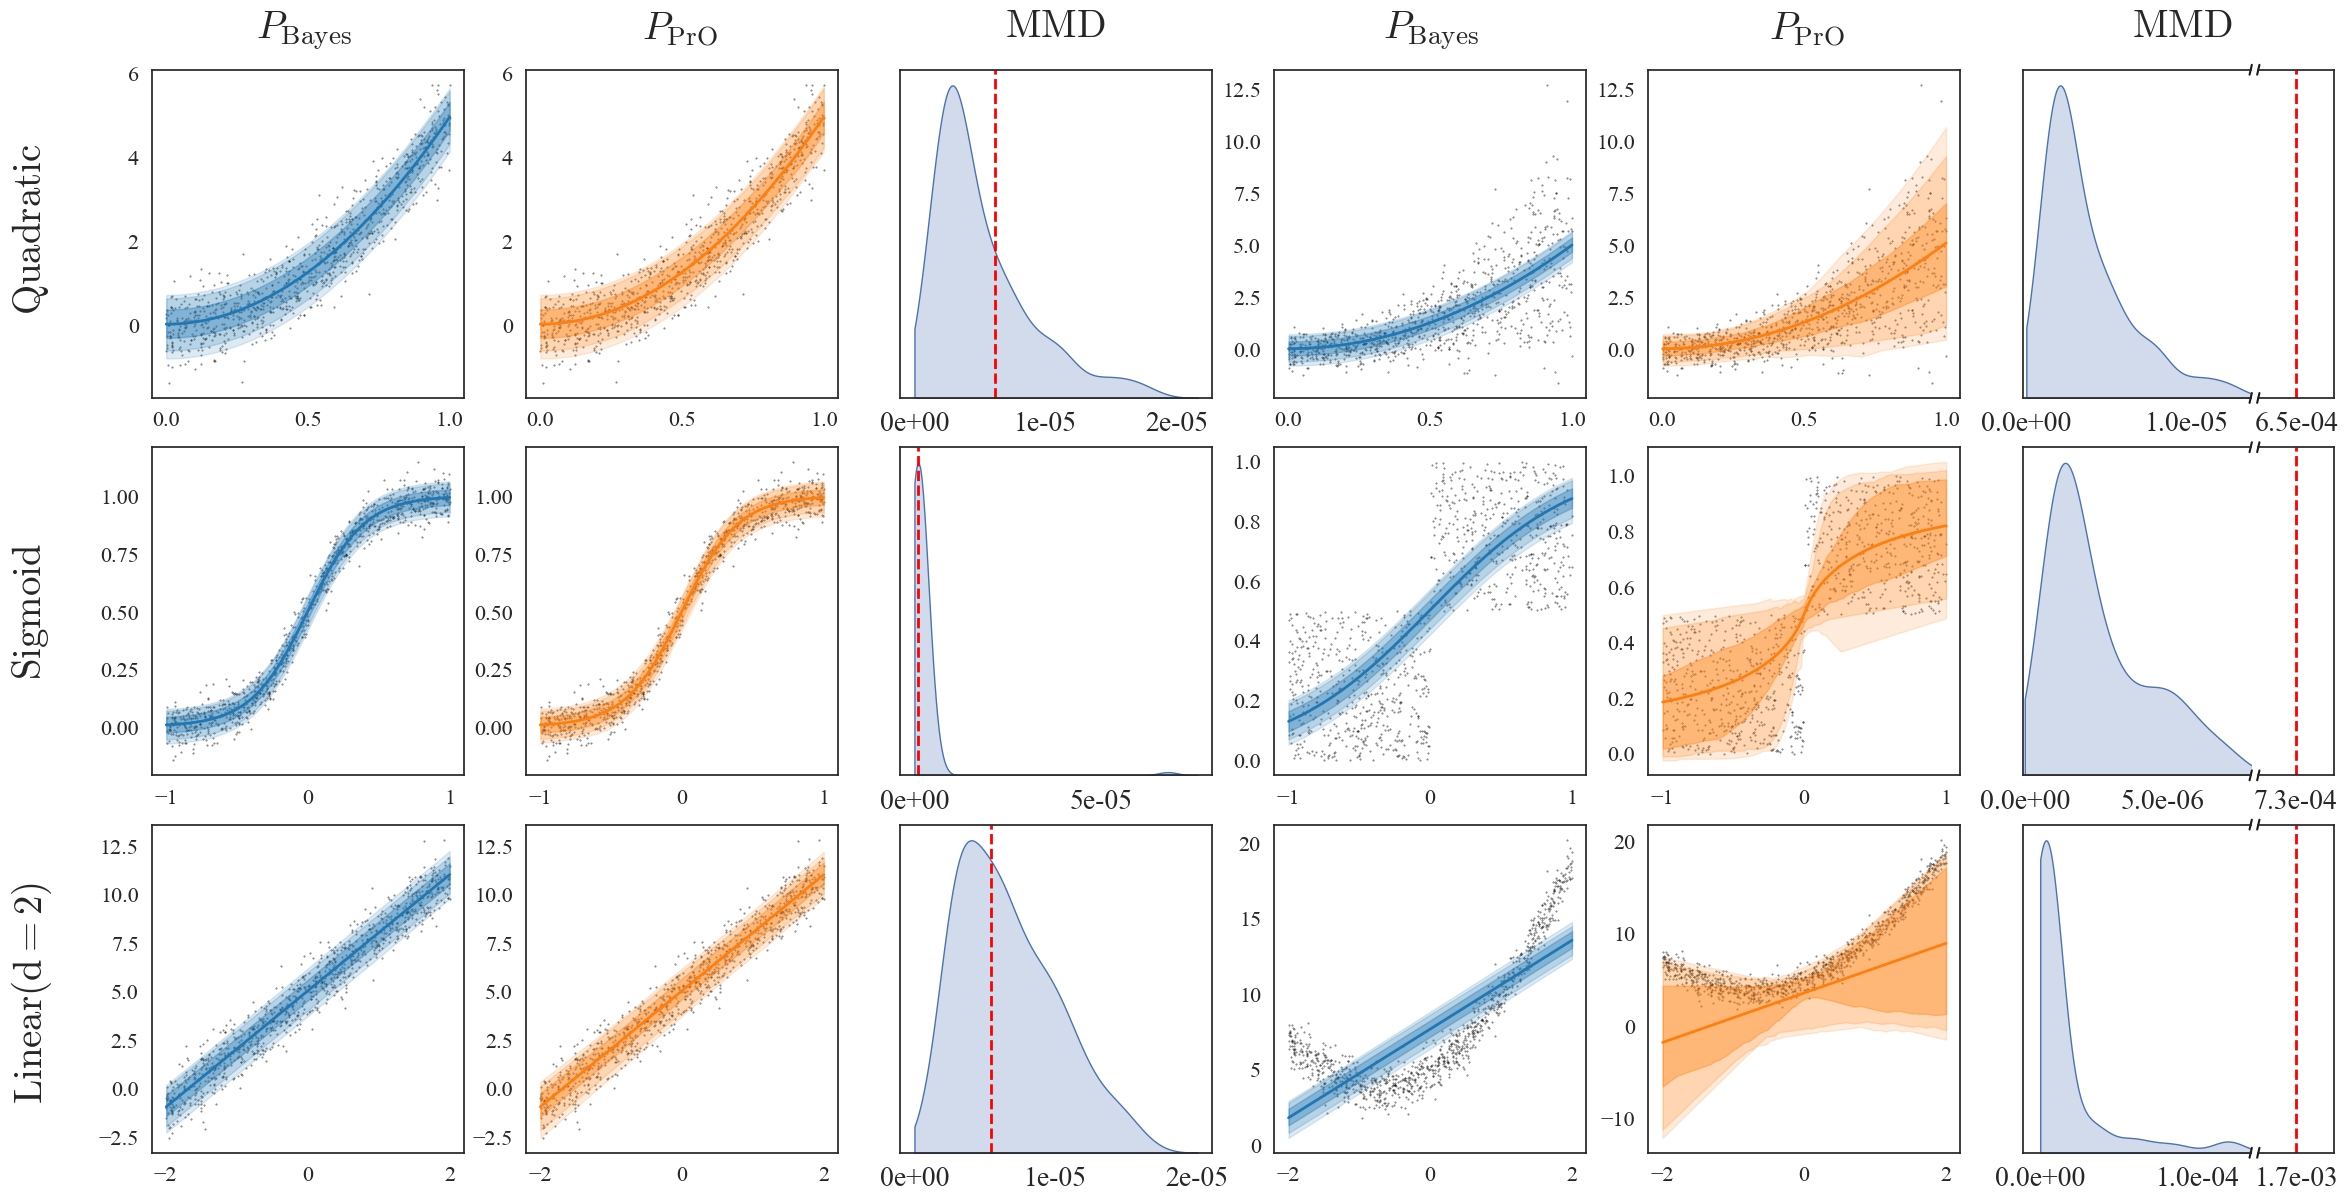

In [2]:
plot_main_figure('main_fig.dill')